# Mai24_CMLOPS_Accidents_Cdc_#2_Modeles

## 1- Analyse de corrélation de variables

In [2]:
# Import des bibliothèques nécessaires au projet
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
#from plotly.offline import init_notebook_mode, iplot
import time

# Ignorer les avertissements
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [3]:
pip install imbalanced-learn

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [16]:
df = pd.read_csv('../src/data/data 2005a2021 final.csv', index_col=0)

In [17]:
# colonne non catégorielle
colonne_Non_cat=['num_acc', 'an_nais', "num_veh", 'annee', 'mois', 'jour', 'com', 'dep', 'hr', 'mn','nbv','lartpc','larrout']

# colonne catégorielle
cat_columns = [col for col in df.columns if col not in colonne_Non_cat]

In [5]:
import scipy.stats as stats

# calcul des corrélations pour les variables catégorielles uniquement
cat_corr = {}
for col in cat_columns:
    contingency_table = pd.crosstab(df['grav'], df[col])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    cat_corr[col] = chi2

print("Chi2 avec 'grav':")
print(cat_corr)

Chi2 avec 'grav':
{'lum': 42586.40576514557, 'agg': 89242.82155143883, 'int': 27733.507655346883, 'atm': 5963.580587186945, 'col': 93221.16170445719, 'catv': 102733.36800586228, 'choc': 49738.91297649023, 'manv': 101043.66215875177, 'place': 38465.963033061285, 'catu': 38293.87715526149, 'grav': 4357946.0, 'sexe': 2682.426360463483, 'trajet': 34449.21679522872, 'catr': 102264.44538582121, 'circ': 36994.1938459717, 'prof': 15249.309644481145, 'plan': 36547.93186768001, 'surf': 3357.507010418821, 'situ': 47764.423170739945}


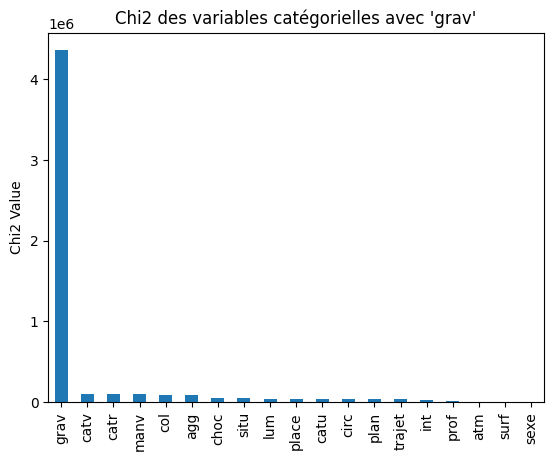

In [6]:
# bar plot pour les résultats du test du chi-carré
cat_corr_series = pd.Series(cat_corr).sort_values(ascending=False)
cat_corr_series.plot(kind='bar')
plt.title("Chi2 des variables catégorielles avec 'grav'")
plt.ylabel('Chi2 Value')
plt.show()

In [18]:
# le nombre de colonnes étant conséquent, nous cherchons à supprimer celles non nécessaires
# les variables atm, annee_y, annee_x, sexe et surf ne semblent pas corrélées avec grav - nous les supprimons donc
colonnes_a_supprimer = ['atm', 'annee', 'sexe', 'surf', "num_veh"]
df = df.drop(columns=colonnes_a_supprimer)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 201200035939 to 201200036992
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mois     49998 non-null  int64  
 1   jour     49998 non-null  int64  
 2   lum      49998 non-null  int64  
 3   agg      49998 non-null  int64  
 4   int      49998 non-null  int64  
 5   col      49998 non-null  float64
 6   com      49998 non-null  int64  
 7   dep      49998 non-null  int64  
 8   hr       49998 non-null  int64  
 9   mn       49998 non-null  int64  
 10  catv     49998 non-null  int64  
 11  choc     49998 non-null  float64
 12  manv     49998 non-null  float64
 13  place    49998 non-null  int64  
 14  catu     49998 non-null  int64  
 15  grav     49998 non-null  int64  
 16  trajet   49998 non-null  float64
 17  an_nais  49998 non-null  int64  
 18  catr     49998 non-null  int64  
 19  circ     49998 non-null  float64
 20  nbv      49998 non-null  int64  
 21 

In [20]:
len(df)

49998

In [21]:
df["grav"].value_counts()

grav
1    38316
3    10336
2     1346
Name: count, dtype: int64

## 2- Préparation du jeu de donnée - pré processing

In [22]:
# on sépare les variables cibles et les caractéristiques
X = df.drop(columns=['grav'])
y = df['grav']

In [23]:
# on divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# nous avons vu dans notre analyse de données que les classes 2 et 3 étaient sous représentées
# afin de régler ce déséquilibre de classe, nous allons faire un SMOTE et l'appliquer à nos données
"""
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
"""

In [17]:
#print('Classes échantillon smote :', dict(pd.Series(y_train_resampled).value_counts()))
#le nombre de l'échantillon a augmenté (environ 4M)
#Classes échantillon smote : {1: 1335601, 3: 1335601, 2: 1335601}
#il vaut mieux utiliserla méthode de RandomUnderSampler

In [24]:
# nous avons vu dans notre analyse de données que les classes 2 et 3 étaient sous représentées
# afin de régler ce déséquilibre de classe, nous allons faire un SMOTE et l'appliquer à nos données

ru =RandomUnderSampler()
X_train_resampled, y_train_resampled = ru.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_resampled).value_counts()))

Classes échantillon undersampled : {1: 1083, 2: 1083, 3: 1083}


## 3- Entrainement de plusieurs modèles

In [23]:
# entrainement d un arbre de decision

model_tree_clf = DecisionTreeClassifier(random_state=42, max_depth=10)

start_time = time.time()
model_tree_clf.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

training_time = end_time - start_time
print(f"Temps d'entraînement du modèle : {training_time:.2f} secondes")

y_pred = model_tree_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Temps d'entraînement du modèle : 1.13 secondes
Confusion Matrix:
[[228469  37135  68612]
 [  1428   7727   2700]
 [ 20429  30158  39137]]

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.68      0.78    334216
           2       0.10      0.65      0.18     11855
           3       0.35      0.44      0.39     89724

    accuracy                           0.63    435795
   macro avg       0.46      0.59      0.45    435795
weighted avg       0.78      0.63      0.68    435795


Accuracy Score:
0.6317947658876306


In [25]:
# entrainement d un random forest

model_rf_clf = RandomForestClassifier(random_state=42)

start_time = time.time()
model_rf_clf.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

training_time = end_time - start_time
print(f"Temps d'entraînement du modèle : {training_time:.2f} secondes")

y_pred = model_rf_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
accuracy=accuracy_score(y_test, y_pred)
print(accuracy)

Temps d'entraînement du modèle : 1.08 secondes
Confusion Matrix:
[[5132 1085 1499]
 [  29  178   56]
 [ 548  752  721]]

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.67      0.76      7716
           2       0.09      0.68      0.16       263
           3       0.32      0.36      0.34      2021

    accuracy                           0.60     10000
   macro avg       0.43      0.57      0.42     10000
weighted avg       0.76      0.60      0.66     10000


Accuracy Score:
0.6031


In [26]:
# on sauvegarde l accuracy en memoire pour qu elle puisse etre communiqué aux admin par notre API
model_data = {
    'model': model_rf_clf,
    'accuracy': accuracy
}

# modifier seuil des tests unitaires pour déclencher le ré-entrainement

In [27]:
# nous souhaitons un modele predisant mieux les gravites eleves,
# on sauvegarde donc le modele avec la meilleure
import joblib
with open('model_rf_clf.pkl', 'wb') as file:
    joblib.dump(model_data, file)